![logo](images/Makeathon_Logo.png)
# Notebook 3 - Computer Vision

In [1]:
##Other
import torch.optim as optim
import os
import copy
import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

##Data & Transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import pandas as pd

#Model
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim


##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from torchmetrics import IoU

##Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

Use CUDA if supported by your machine

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1- Image classification

The dataset consists of images from 4 different weather conditions: cloudy, rain, shine and sunrise. According to the authors, the dataset provides a platform for outdoor weather analysis by extracting various features for recognizing different weather conditions (https://data.mendeley.com/datasets/4drtyfjtfy).

Download the dataset here: https://drive.google.com/drive/folders/1vxLdJdjgYDA6Hox1tXJ9d1SDJBhqg6lB?usp=sharing

The structure is as follows:

- Images (contains all images)
- train_labels.csv (contains the name of images used for training and their corresponding label)
- val_labels.csv (contains the name of images used for validation and their corresponding label)
    
Originally the name of the class was encoded in the image name; however, we already created a train and validation csv which mapped the names to the numbers 0 : cloudy, 1 : rain, 2 : shine and 3 : sunrise
First of we will create a dataset class based on PyTorchs own dataset class (https://pytorch.org/tutorials/beginner/data_loading_tutorial.html):

In [3]:
class MCWeatherDataset(Dataset):
    def __init__(self,img_dir,target_file,transform=None):
        self.img_labels = target_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        try:
            if self.transform:
                image = self.transform(image)
        except:
            print(img_path)

        return {'Image':image,'Label':label}

Let's visualize some images from the dataset:

In [4]:
train_df = pd.read_csv('$your_path$/train_labels.csv')
val_df = pd.read_csv('$your_path$/val_labels.csv')
dataset = MCWeatherDataset('$your_path$/Images/',target_file=train_df)

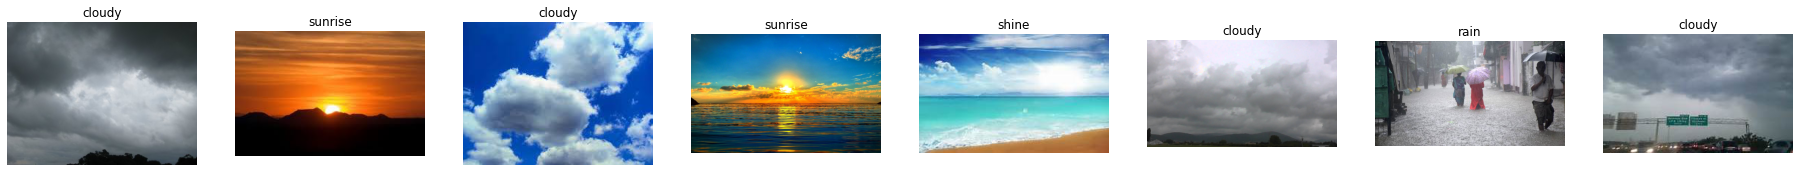

In [5]:
LABEL_MAP = {0:"cloudy",
             1:"rain",
             2:"shine",
             3:"sunrise"}

fig,axes = plt.subplots(ncols=8,figsize=(4*8,4))

for i in range(8):
    data = dataset[i]
    vis = data['Image']
    title = LABEL_MAP[data['Label']]
    axes[i].imshow(vis)
    axes[i].axis('off')
    axes[i].set_title(title)


Above, you can see eight images from the dataset with their respective class written on top of each. Next up, we will create the transformations we will use on the images. Because we use a pre-trained network, we need to resize the images to 224x224 and normalize the image according to the mean & standard deviation channel values from the pre-trained dataset. In our case, that's ImageNet. Feel free to add some data augmentations if you want to. Let's visualize some images from the dataset:

In [6]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_transform = T.Compose([T.Resize((224,224)),
                             T.ToTensor(),
                            T.Normalize(*stats,inplace=True)])
val_transform = T.Compose([T.Resize((224,224)),
                           T.ToTensor(),
                        T.Normalize(*stats,inplace=True)])

In [7]:
train_dataset = MCWeatherDataset('$your_path$/Images/',target_file=train_df,transform=train_transform)
val_dataset = MCWeatherDataset('$your_path$/Images/',target_file=val_df,transform=val_transform)
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=16,shuffle=False)

### About the Model

There is a variety of different models for image classification (AlexNet, VGG, ResNet, ResNext, WideResNet, DenseNet, Inception V3, SqueezeNet, GoogLeNet, etc.). We will use a ResNet (Residual Network) which introduced the idea of residual blocks to address the vanishing gradient problem. As you can see below, these blocks contain identity shortcut connections to skip one or more layers, which allows training deeper architectures. There are different "depths" of  ResNets (ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-110, ResNet-152, ResNet-164, ... ). We will use the ResNet-18, which you can see below:

![resnet18](images/resnet18.png)  ![residual_learning](images/residual_learning.png) 

For more information about ResNets:
- https://cv-tricks.com/keras/understand-implement-resnets/
- https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

Link to the original Paper : https://arxiv.org/abs/1512.03385

#### Create & modify the model
We will use a pre-trained version of ResNet18 from PyTorch (https://pytorch.org/vision/stable/models.html#classification). 

In [8]:
model = torchvision.models.resnet18(pretrained=True) #Download model

#To change the head of the network we need to know how many input features the head gets
num_infeatures = model.fc.in_features

#Next we will change the head and s.t. the output size is adapted to our task (in our case 4)
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_infeatures, 4)

#Move model to cuda 
model_ft = model.to(device)

### Training
To facilitate the training we created a trainer class which takes care of everything. Of course, this is just a very basic implementation, and a lot can be extended. For logging purposes, we will use tensorboard. Either run the cell below the next one or start tensorboard in your terminal. (For more see: https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html)

In [9]:
class MCWeatherTrainer(object):
    
    def __init__(self,model,criterion,optimizer,device,logger):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.logger = logger
        self.best_loss = 1e6
        self.best_model_weights = copy.deepcopy(self.model.state_dict())
    
    def train(self,train_dataloader,val_dataloader,num_epochs):
        
        self.dataloaders = {}
        self.dataloaders['train'] = train_dataloader
        self.dataloaders['val'] = val_dataloader
        
        for epoch in tqdm(range(num_epochs),total=num_epochs):
            
            self.training_phase(epoch)
            self.validation_phase(epoch)
        
        
    def training_phase(self,epoch):
        
        self.model.train()
        
        running_loss = 0.0
        predictions = []
        gt = []
        for batch in self.dataloaders['train']:
            images = batch['Image']
            labels = batch['Label']
            
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            self.optimizer.zero_grad()
            logits = self.model(images)
            _, preds = torch.max(logits, 1)
            loss = self.criterion(logits, labels)
            
            
            gt.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            running_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            
        
        epoch_loss = running_loss / len(self.dataloaders['train'])
        f1 = f1_score(gt,predictions,average='weighted')
        self.logger.add_scalar('Loss/train',epoch_loss,epoch)
        self.logger.add_scalar('F1/train',f1,epoch)

            
            
    def validation_phase(self,epoch):
        
        self.model.eval()
        
        running_loss = 0.0
        predictions = []
        gt = []
        for batch in self.dataloaders['val']:
            images = batch['Image']
            labels = batch['Label']
            
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            with torch.no_grad():
                logits = self.model(images)
            _, preds = torch.max(logits, 1)
            loss = self.criterion(logits, labels)
            
            gt.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            running_loss += loss.item()
            

            
        epoch_loss = running_loss / len(self.dataloaders['val'])
        f1 = f1_score(gt,predictions,average='weighted')
        self.logger.add_scalar('Loss/val',epoch_loss,epoch)
        self.logger.add_scalar('F1/val',f1,epoch)
        
        if epoch_loss < self.best_loss:
            self.best_loss = epoch_loss
            self.best_model_weights = copy.deepcopy(self.model.state_dict())
        
    def get_best_model(self):
        self.model.load_state_dict(self.best_model_weights)
        return self.model

In [10]:
%load_ext tensorboard 
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 17268), started 2 days, 2:44:13 ago. (Use '!kill 17268' to kill it.)

In [11]:
#Logger
logger = SummaryWriter() 
#Loss Function
criterion = nn.CrossEntropyLoss()
#Optimizer 
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
#Trainer instance
trainer = MCWeatherTrainer(model_ft,criterion,optimizer_ft,device,logger)

In [12]:
trainer.train(train_dataloader,val_dataloader,5)
logger.flush()
logger.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:18<00:00, 15.67s/it]


### Evaluation
After the training let's get the best model and make some predictions on the validation set. (Normally you would use your test set here)

In [13]:
model = trainer.get_best_model().to('cpu')
gt = []
predictions = []
images = []
probabilities = []
for sample in val_dataset:
    image = sample['Image']
    label = sample['Label']
    
    images.append(image)
    
    logits = model(image.unsqueeze(0))
    _, preds = torch.max(logits, 1)
    
    gt.append(label)
    predictions.append(preds.item())
    probabilities.append(nn.Softmax(dim=1)(logits).squeeze().detach().numpy())

In [14]:
print(classification_report(gt, predictions, target_names=['cloudy','rain','shine','sunrise']))

              precision    recall  f1-score   support

      cloudy       0.98      0.98      0.98        60
        rain       1.00      1.00      1.00        43
       shine       0.98      0.98      0.98        51
     sunrise       1.00      1.00      1.00        71

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



<AxesSubplot:>

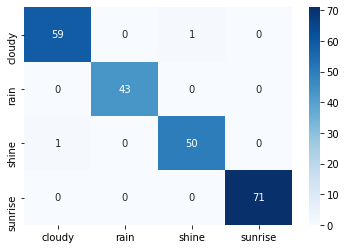

In [15]:
sns.heatmap(confusion_matrix(gt,predictions),annot=True, fmt='d',xticklabels=['cloudy','rain','shine','sunrise'],yticklabels=['cloudy','rain','shine','sunrise'],cmap='Blues')

As you can see even with a few lines of code, we could adapt a pre-trained model to a new image classification task with good results!

# 2- Semantic segmentation

### Pratheepan dataset
The Pratheepan dataset is downloaded randomly from Google for human skin detection research. These images are captured with a range of different cameras using different color enhancement and under different illuminations. (http://cs-chan.com/project1.htm)

Download the dataset here: https://drive.google.com/drive/folders/1sT67gIwueMUsF1XodJ7wkz_Yrp2pxTO6?usp=sharing

The structure is as follows:

- Images (Images in .jpg format)
    - train
    - val
- Masks (Segmentation masks in .png format)
    - train
    - val
    
First of we will again create a dataset class:

In [16]:
class FaceDataset(Dataset):
    def __init__(self, root,mode,transforms=None):
        self.root = root
        self.transforms = transforms
        self.mode = mode

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images",self.mode))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Masks",self.mode))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images",self.mode,self.imgs[idx])
        mask_path = os.path.join(self.root, "Masks",self.mode,self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert('P')
        mask = np.array(mask)
        mask[mask>0] = 1
        

        if self.transforms is not None:
            img = self.transforms(img)   

        
        return {'Image':img,'Label':torch.Tensor(mask)}
    
    def __len__(self):
        return len(self.imgs)

Let´s visualize the dataset:

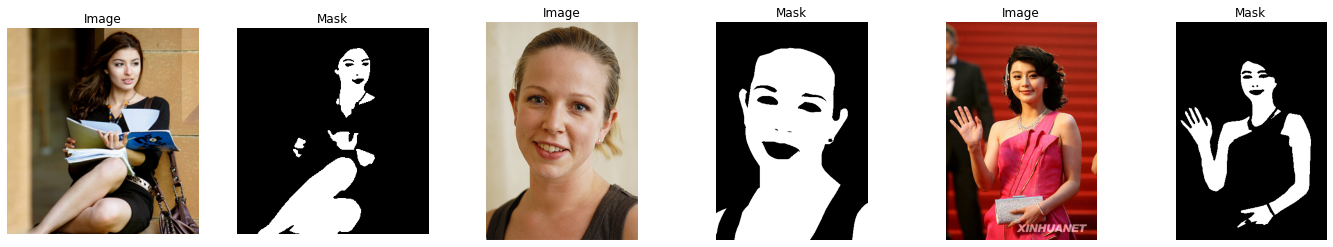

In [17]:
dataset = FaceDataset('$your_path$/Face_Dataset/',mode='train',transforms=None)

fig,axes = plt.subplots(ncols=6,figsize=(4*6,4))

for i in range(6):
    data = dataset[i//2]
    if i%2 == 0:
        title = "Image" 
        vis = np.array(data['Image'])
        cmap = None 
    else:
        title = "Mask"
        vis = np.array(data['Label'])
        cmap = 'Greys_r'
        
    axes[i].imshow(vis,cmap=cmap)
    axes[i].axis('off')
    axes[i].set_title(title)


Above, you can see three examples of image mask pairs. Since we have a binary segmentation problem, we only have two classes : 0 - Background 1 - Skin 

Next, off we will create the transformations. In contrast to the image classification problem, we won't resize the images in the Dataset class but rather when "collecting" from the Dataloader. The reason for that is that we want to resize the images dynamically based on the median height & aspect ratio of the batch to reduce distortion artifacts. So feel free to choose any other strategy. However, be careful that when spatially transforming your image, you need to do the same with the mask!

In [18]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transforms = T.Compose([T.ToTensor(),
                        T.Normalize(*stats,inplace=True)])


def collate_fn(batch):
    
    image_shapes = np.array([item['Image'].size() for item in batch])
    median_height = np.median(image_shapes,axis=0)[1]
    median_aspect_ratio = np.median(image_shapes[:,1] / image_shapes[:,2])
    
    height = int(median_height)
    height = 256 if height > 256 else height #This is just so it fits into the GPU Memory. If possible don´t use it
    width = int(height*median_aspect_ratio)
    
    
    imageResize = T.Resize((height,width))
    maskResize = T.Resize((height,width),interpolation=torchvision.transforms.InterpolationMode.NEAREST)
    
    
    images = [imageResize(item['Image']) for item in batch]
    masks = [maskResize(item['Label'].unsqueeze(0)).squeeze(0) for item in batch]
    
    images = torch.stack(images)
    masks = torch.stack(masks)
    
    return {'Image':images,'Label':masks}

In [19]:
train_dataset = FaceDataset('$your_path$/Face_Dataset/',mode='train',transforms=transforms)
val_dataset = FaceDataset('$your_path$/Face_Dataset/',mode='val',transforms=transforms)
train_dataloader = DataLoader(train_dataset,batch_size=2,shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,batch_size=2,shuffle=False,collate_fn=collate_fn)

### About the Model

There are different semantic segmentation models (FCN, UNet, DeepLab, etc.). We will use the DeepLabV3 network, which you can see below - in case you're interested, there is also a DeepLabV1, DeepLabV2 and DeepLabV3+.

#### DeepLabV3 

![deeplabv3](images/deeplabv3.png)

The DeepLabV3 network has the following architecture:

- A backbone network is responsible for extracting features (in our case, that's a ResNet 50 - of course also other networks like DenseNet are possible)
- To segmenting objects at multiple scales, Atrous Convolutions are used in the last few blocks with multiple atrous rates 
- The extracted features from the backbone are then fed into a Atrous Spatial Pyramid Pooling module (ASPP) 
- The output of the ASPP module is then passed through a 1 x 1 convolution to obtain the final segmentation mask

Original paper: Rethinking Atrous Convolution for Semantic Image Segmentation (https://arxiv.org/abs/1706.05587v3)

To read more about Atrous Convolutions, ASPP or DeepLabV3 in general, check out:
- https://developers.arcgis.com/python/guide/how-deeplabv3-works/
- https://towardsdatascience.com/review-deeplabv3-atrous-convolution-semantic-segmentation-6d818bfd1d74

#### Create & modify the model
As for the classification task, we will use the pre-trained version of DeepLabV3 from PyTorch (https://pytorch.org/vision/stable/models.html#semantic-segmentation). There are three different backbone options available (ResNet50,ResNet101 and MobileNetV3-Large). We will use the first one. The model has been trained on a subset of COCO train2017, on the 20 categories present in the Pascal VOC dataset.

In [20]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

#Get the pretrained Model
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)

#Change the classifier head so that it fits to our number of classes = 2
#In_channels is the number of feature maps the backbone outputs, which is 2048 in our case
model.classifier = DeepLabHead(in_channels=2048, num_classes=2)

model_ft = model.to(device)

#### Train the model
For the loss & metric logs, you can either scroll up to the embedded tensorboard or open tensorboard on the local port you started it.

In [21]:
class FaceTrainer(object):
    
    def __init__(self,model,criterion,optimizer,device,logger):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.logger = logger
        self.best_loss = 1e6
        self.best_model_weights = copy.deepcopy(self.model.state_dict())
        self.iou = IoU(num_classes=2)
    
    def train(self,train_dataloader,val_dataloader,num_epochs):
        
        self.dataloaders = {}
        self.dataloaders['train'] = train_dataloader
        self.dataloaders['val'] = val_dataloader
        
        for epoch in tqdm(range(num_epochs),total=num_epochs):
            
            self.training_phase(epoch)
            self.validation_phase(epoch)
        
        
    def training_phase(self,epoch):
        
        self.model.train()
        
        running_loss = 0.0
        running_iou = 0.0
        for batch in self.dataloaders['train']:
            images = batch['Image']
            labels = batch['Label']
            
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            self.optimizer.zero_grad()
            logits = self.model(images)['out'] #output['out'] contains the semantic masks, and output['aux'] contains the auxillary loss values per-pixe
            _, preds = torch.max(logits, 1)


            loss = self.criterion(logits, labels.long())
            running_loss += loss.item()
            running_iou += self.iou(preds.cpu(),labels.int().cpu())  #we need to do it like this because we can`t stack prediction due to different shapes of the batches


            loss.backward()
            self.optimizer.step()
            
        epoch_loss = running_loss / len(self.dataloaders['train'])
        epoch_iou = running_iou / len(self.dataloaders['train'])
        self.logger.add_scalar('IoU/train',epoch_iou,epoch)
        self.logger.add_scalar('Loss/train',epoch_loss,epoch)


            
            
    def validation_phase(self,epoch):
        
        self.model.eval()
        
        running_loss = 0.0
        running_iou = 0.0
        for batch in self.dataloaders['val']:
            images = batch['Image']
            labels = batch['Label']
            
            images = images.to(self.device)
            labels = labels.to(self.device)
            with torch.no_grad():
                logits = self.model(images)['out']
            _, preds = torch.max(logits, 1)
            loss = self.criterion(logits, labels.long())
            running_loss += loss.item()
            running_iou += self.iou(preds.cpu(),labels.int().cpu())  #we need to do it like this because we can`t stack prediction due to different shapes of the batches

            
        epoch_loss = running_loss / len(self.dataloaders['val'])
        epoch_iou = running_iou / len(self.dataloaders['val'])
        self.logger.add_scalar('IoU/val',epoch_iou,epoch)
        self.logger.add_scalar('Loss/val',epoch_loss,epoch)

        
        if epoch_loss < self.best_loss:
            self.best_loss = epoch_loss
            self.best_model_weights = copy.deepcopy(self.model.state_dict())
        
    def get_best_model(self):
        self.model.load_state_dict(self.best_model_weights)
        return self.model

In [22]:
#Logger 
logger = SummaryWriter() 
#Loss
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
#Trainer instance
trainer = FaceTrainer(model_ft,criterion,optimizer_ft,device,logger)

In [23]:
trainer.train(train_dataloader,val_dataloader,50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:41<00:00,  9.23s/it]


### Evaluation
Let´s take an example from the validation set and look at how good the prediction of our model is:

In [24]:
data = val_dataset[6]
model = trainer.get_best_model().to('cpu')
logits = model(data['Image'].unsqueeze(0))['out']
preds = torch.argmax(logits,dim=1).squeeze()
example_iou = np.round(IoU(2)(preds,torch.Tensor(data['Label']).type(torch.int)).item(),4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction | IoU: 0.8898')

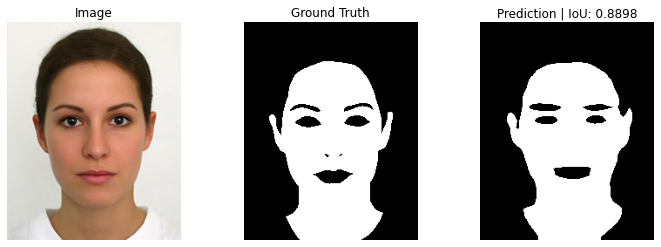

In [25]:
fig,axes = plt.subplots(ncols=3,figsize=(12,4))


axes[0].imshow(np.multiply(data['Image'].permute(1,2,0),np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))
axes[0].axis('off')
axes[0].set_title("Image")
axes[1].imshow(data['Label'],cmap="Greys_r")
axes[1].axis('off')
axes[1].set_title("Ground Truth")
axes[2].imshow(torch.argmax(logits,dim=1)[0],cmap="Greys_r")
axes[2].axis('off')
axes[2].set_title(f"Prediction | IoU: {example_iou}")

# 3- Object detection

Note that this tutorial is very similar to https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html, except we will demonstrate object detection and not instance segmentation.

### Penn-Fudan Database for Pedestrian Detection and Segmentation

This is an image database containing images that are used for pedestrian detection. The images are taken from scenes around campus and urban streets. The objects we are interested in these images are pedestrians. Each image will have at least one pedestrian in it. (https://www.cis.upenn.edu/~jshi/ped_html/)

Download the dataset here: https://drive.google.com/drive/folders/1BG7gIqv9oE0GMedDK_tnqfIYFshLExRI?usp=sharing
The structure is as follows:

- PNGImages
    - train
    - val
- PedMasks
    - train
    - val
    
First of we will again create a dataset class:

In [3]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root,mode):
        self.root = root
        self.mode = mode
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages",self.mode))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks",self.mode))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.mode,self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.mode,self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        return T.ToTensor()(img), target

    def __len__(self):
        return len(self.imgs)

In [38]:
dataset = PennFudanDataset('$your_path$/PennFudanPed/',mode="val")

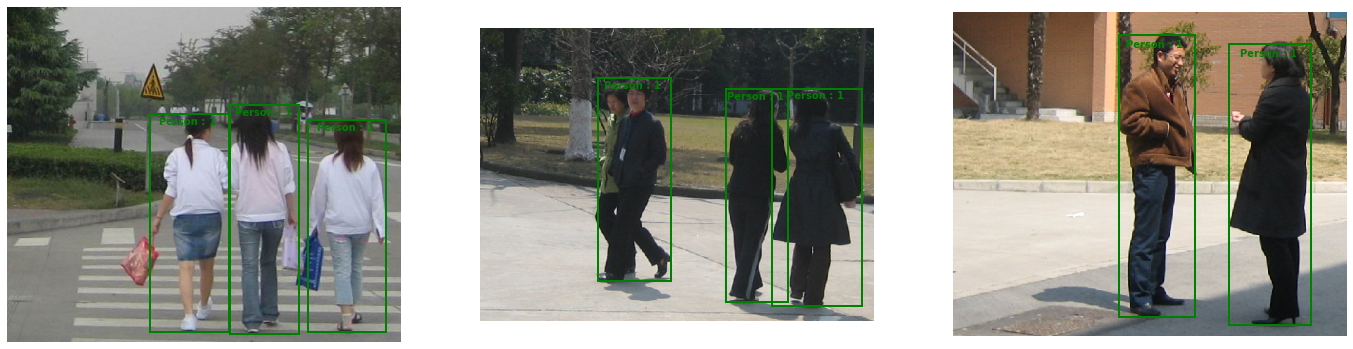

In [39]:
fig,axes = plt.subplots(ncols=3,figsize=(24,16))

for i in range(3):
    data = dataset[i]
    image = data[0]
    info = data[1]

    for box,label in zip(info['boxes'],info['labels']):
        rect = patches.Rectangle((box[0], box[1]), box[2] -box[0],box[3]-box[1],linewidth=2, edgecolor='g', facecolor='none')
        axes[i].add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + 10 
        axes[i].annotate(f"Person : {label} ", (cx, cy), color='g', weight='bold', fontsize=10, ha='center', va='center')


    axes[i].imshow(image.permute(1,2,0))
    axes[i].axis('off')

So each image has for each person a corresponding bounding box assigned with the class label, which is in our case 1. 

In [40]:
def collate_fn(batch):
    return tuple(zip(*batch))

val_dataset = PennFudanDataset('$your_path$/PennFudanPed/',mode="train")
val_dataset = PennFudanDataset('$your_path$/PennFudanPed/',mode="val")
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False,collate_fn=collate_fn)

### About the model

The architecture of Faster R-CNN is shown below. It consists of 2 modules:

1. RPN: For generating region proposals.
2. Fast R-CNN: For detecting objects in the proposed regions.

<div>
<img src="images/faster_rcnn.png" width="500">
</div>

The Faster R-CNN works as follows:

- The RPN generates region proposals
- For all region proposals in the image, a fixed-length feature vector is extracted from each region using the ROI Pooling layer.
- The extracted feature vectors are then classified using the Fast R-CNN.
- The class scores of the detected objects in addition to their bounding-boxes are returned.

Fore more information refer to : 
- https://blog.paperspace.com/faster-r-cnn-explained-object-detection/
- https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/
- https://towardsdatascience.com/faster-r-cnn-for-object-detection-a-technical-summary-474c5b857b46

Link to original paper : https://arxiv.org/abs/1506.01497

#### Create & modify the model
As for the other two tasks, we will use a pre-trained version of Faster R-CNN from PyTorch with a ResNet50 Backbone (https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection). 

In [41]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model_ft = model.to(device)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

#### Train the model
In contrast to the other two tutorials, we won´t create a trainer class here but rather use pre-defined functions from the following repository: https://github.com/pytorch/vision/tree/main/references/detection. Note that we have already created the four scripts you will need:
- coco_eval.py
- coco_utils.py
- engine.py
- utils.py

In [42]:
from engine import train_one_epoch,evaluate

num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_ft, optimizer_ft, train_dataloader, device, epoch, print_freq=10)
    # evaluate on the test dataset
    evaluate(model_ft, val_dataloader, device=device)

Epoch: [0]  [ 0/69]  eta: 0:02:17  lr: 0.000100  loss: 1.1745 (1.1745)  loss_classifier: 0.9249 (0.9249)  loss_box_reg: 0.2346 (0.2346)  loss_objectness: 0.0143 (0.0143)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.9983  data: 0.7748  max mem: 3718
Epoch: [0]  [10/69]  eta: 0:01:01  lr: 0.000100  loss: 0.4657 (0.5090)  loss_classifier: 0.1504 (0.2359)  loss_box_reg: 0.2408 (0.2541)  loss_objectness: 0.0061 (0.0099)  loss_rpn_box_reg: 0.0098 (0.0091)  time: 1.0389  data: 0.1682  max mem: 3718
Epoch: [0]  [20/69]  eta: 0:00:47  lr: 0.000100  loss: 0.2822 (0.4077)  loss_classifier: 0.0966 (0.1659)  loss_box_reg: 0.1641 (0.2215)  loss_objectness: 0.0026 (0.0085)  loss_rpn_box_reg: 0.0100 (0.0117)  time: 0.9222  data: 0.0976  max mem: 3718
Epoch: [0]  [30/69]  eta: 0:00:37  lr: 0.000100  loss: 0.2430 (0.3557)  loss_classifier: 0.0729 (0.1352)  loss_box_reg: 0.1460 (0.2021)  loss_objectness: 0.0026 (0.0072)  loss_rpn_box_reg: 0.0100 (0.0113)  time: 0.9302  data: 0.0941  max mem: 3718
Epoch: [

### Evaluation
Let´s take an example from the validation set and look at how good the prediction of our model is:

In [45]:
images,targets = next(iter(val_dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

model_ft.eval()
model_ft.to('cpu')
output = model(images)

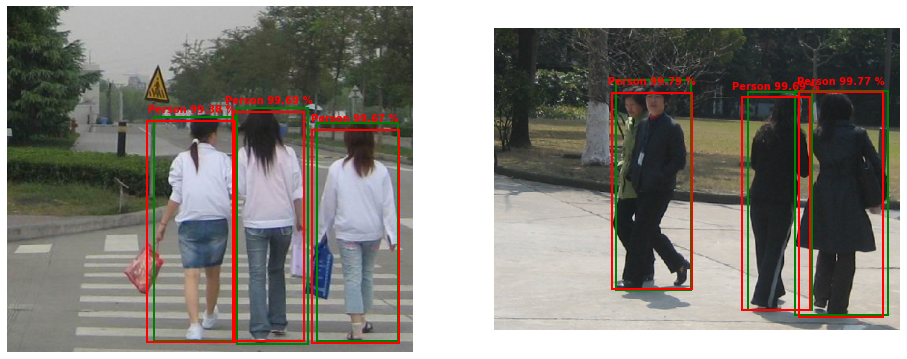

In [46]:
fig,axes = plt.subplots(ncols=2,figsize=(16,16))

for i in range(2):
    target = targets[i]
    sample = output[i]

    for box in target['boxes']:
        rect = patches.Rectangle((box[0], box[1]), box[2] -box[0],box[3]-box[1],linewidth=2, edgecolor='g', facecolor='none')
        axes[i].add_patch(rect)

    for box,label,score in zip(sample['boxes'].detach(),sample['labels'],sample['scores']):
        rect = patches.Rectangle((box[0], box[1]), box[2] -box[0],box[3]-box[1],linewidth=2, edgecolor='r', facecolor='none')
        axes[i].add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry - 15 #+ rect.get_height()
        score = np.round(score.item()*100,2)
        axes[i].annotate(f"Person {score} %", (cx, cy), color='red', weight='bold', fontsize=10, ha='center', va='center')

    axes[i].imshow(images[i].permute(1,2,0))
    axes[i].axis('off')